In [2]:
import pandas as pd

DATA_DIR = "../Data/processed/"

X_train = pd.read_csv(DATA_DIR + "X_train_preprocessed.csv")
X_test  = pd.read_csv(DATA_DIR + "X_test_preprocessed.csv")
y_train = pd.read_csv(DATA_DIR + "y_train.csv").squeeze()
y_test  = pd.read_csv(DATA_DIR + "y_test.csv").squeeze()

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((214491, 42), (53623, 42), (214491,), (53623,))

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

# Create model (balanced handles class imbalance)
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1)

# Train
log_reg.fit(X_train, y_train)

# Predict probabilities
probs_lr = log_reg.predict_proba(X_test)[:, 1]

# Metrics
roc_lr = roc_auc_score(y_test, probs_lr)
prec, rec, _ = precision_recall_curve(y_test, probs_lr)
pr_auc_lr = auc(rec, prec)

roc_lr, pr_auc_lr


(0.9121487181914669, 0.9715600390559352)

In [4]:
import joblib
joblib.dump(log_reg, "../Models/baseline_logistic.pkl")


['../Models/baseline_logistic.pkl']

In [5]:
!pip install xgboost

In [6]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

# Train
xgb_model.fit(X_train, y_train)

# Predict probabilities
probs_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Metrics
roc_xgb = roc_auc_score(y_test, probs_xgb)
prec, rec, _ = precision_recall_curve(y_test, probs_xgb)
pr_auc_xgb = auc(rec, prec)

roc_xgb, pr_auc_xgb


(0.9190286112308126, 0.9739505635429118)

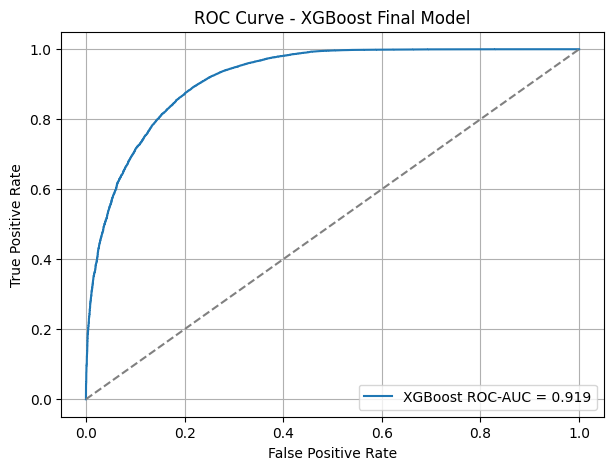

In [7]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, probs_xgb)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'XGBoost ROC-AUC = {roc_xgb:.3f}')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost Final Model")
plt.legend()
plt.grid(True)
plt.show()


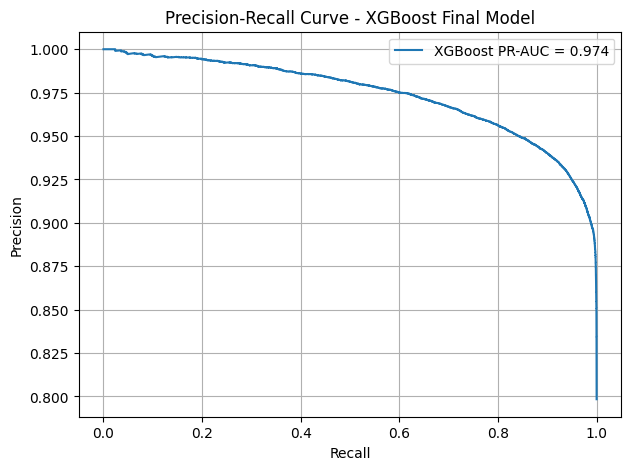

In [11]:
from sklearn.metrics import precision_recall_curve

prec, rec, _ = precision_recall_curve(y_test, probs_xgb)

plt.figure(figsize=(7,5))
plt.plot(rec, prec, label=f'XGBoost PR-AUC = {pr_auc_xgb:.3f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - XGBoost Final Model")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
import joblib
joblib.dump(xgb_model, "../Models/final_xgboost_model.pkl")


['../Models/final_xgboost_model.pkl']

In [13]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, probs_xgb)
j_scores = tpr - fpr
best_idx = j_scores.argmax()
best_threshold = thresholds[best_idx]

best_threshold

np.float32(0.78556746)

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

preds_best = (probs_xgb >= best_threshold).astype(int)
cm = confusion_matrix(y_test, preds_best)
acc = accuracy_score(y_test, preds_best)
f1 = f1_score(y_test, preds_best)

cm, acc, f1


(array([[ 8451,  2358],
        [ 4604, 38210]]),
 0.8701676519403987,
 0.9165047612194478)